# **Импорт данных**

In [ ]:
# библиотеки
library(dplyr)
library(readr)

In [ ]:
df <- read_csv("/content/winequality-red.csv")
head(df)

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


# **Корреляционная матрица Пирсона**

In [ ]:
install.packages("ggcorrplot")
library(ggcorrplot)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘reshape2’


Loading required package: ggplot2



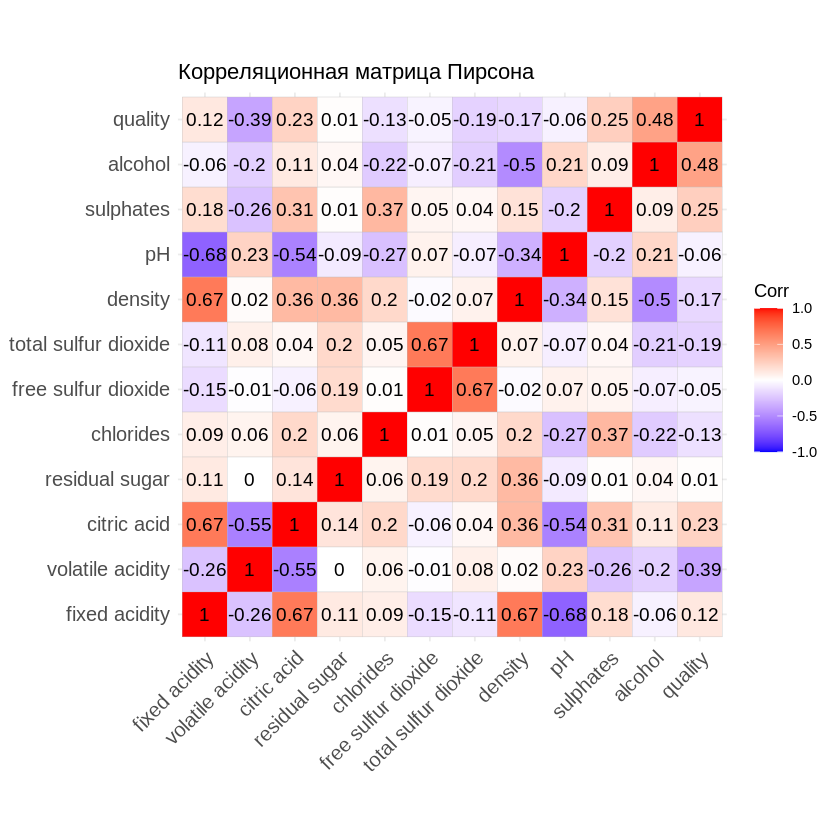

In [ ]:
# Корреляционная матрица Пирсона
pearson_corr <- cor(df, method = "pearson")
ggcorrplot(pearson_corr, lab = TRUE, title = "Корреляционная матрица Пирсона")

# **Визуализация начальных распределений**

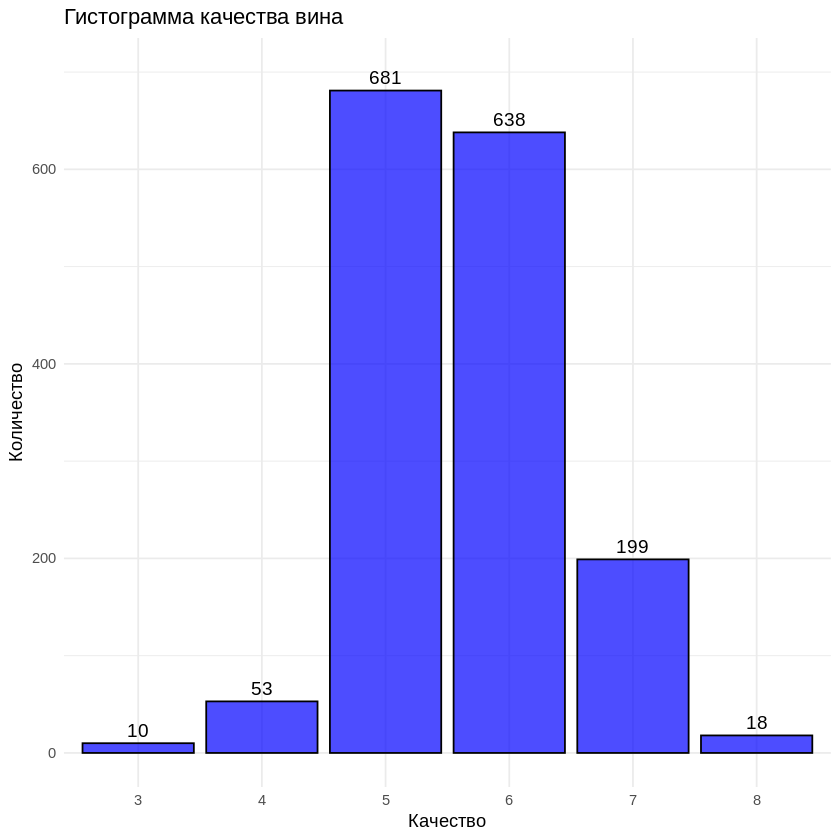

In [ ]:
library(ggplot2)

# Гистограмма качества вина
ggplot(df, aes(x = factor(quality))) +
  geom_bar(fill = "blue", color = "black", alpha = 0.7) +
  geom_text(stat = "count", aes(label = ..count..),
            vjust = -0.5, color = "black", size = 4) +
  scale_y_continuous(limits = c(0, 700)) +
  labs(title = "Гистограмма качества вина",
       x = "Качество",
       y = "Количество") +
  theme_minimal()

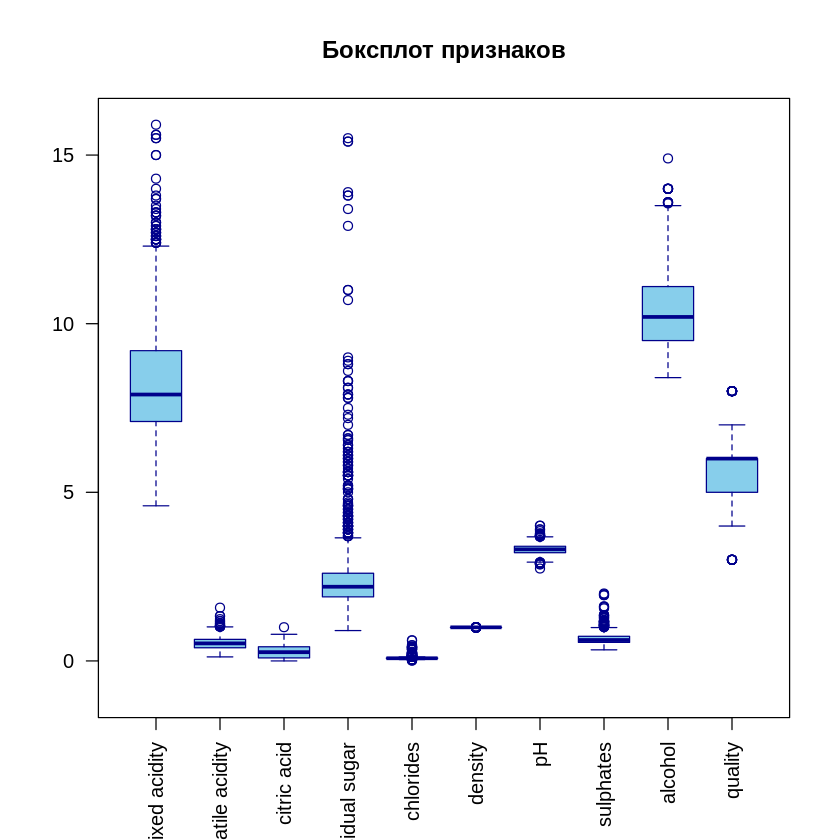

In [ ]:
# Боксплот признаков без диоксидов, без обработки выбросов
df_subset <- subset(df, select = -c(`free sulfur dioxide`, `total sulfur dioxide`))

boxplot(df_subset,
        main = "Боксплот признаков",
        las = 2,
        col = "skyblue",
        border = "darkblue",
        ylim = c(-1, 16)
        )

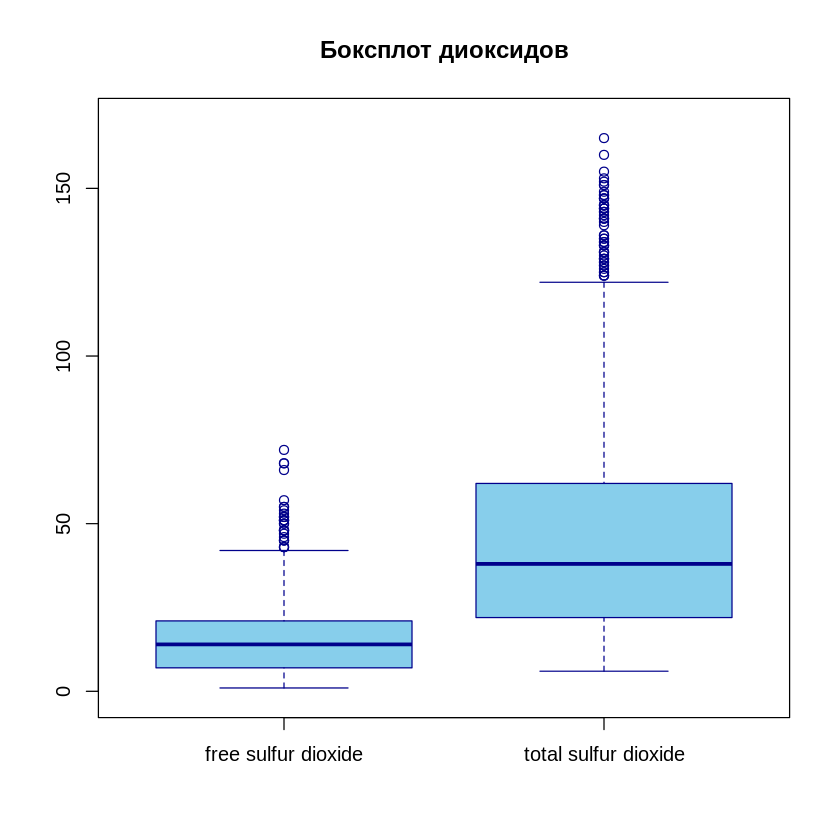

In [ ]:
# Боксплот диоксидов
df_dioxide <- subset(df, select = c(`free sulfur dioxide`, `total sulfur dioxide`))
boxplot(df_dioxide,
        main = "Боксплот диоксидов",
        col = "skyblue",
        border = "darkblue",
        ylim = c(-1, 170)
        )

In [ ]:
# расчет Мода Дисперсия Стандарт_откл без обработки
get_mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}


result <- data.frame(
  Мода = sapply(df, get_mode),
  Дисперсия = sapply(df_no_outliers, var, na.rm = TRUE),
  Стандарт_откл = sapply(df_no_outliers, sd, na.rm = TRUE)
)

print(result)

                        Мода    Дисперсия Стандарт_откл
fixed acidity         7.2000 2.134918e+00   1.461135712
volatile acidity      0.6000 2.718520e-02   0.164879358
citric acid           0.0000 3.247494e-02   0.180208033
residual sugar        2.0000 1.955054e-01   0.442159939
chlorides             0.0800 2.045028e-04   0.014300449
free sulfur dioxide   6.0000 7.777616e+01   8.819079321
total sulfur dioxide 28.0000 6.804160e+02  26.084785606
density               0.9972 2.574086e-06   0.001604396
pH                    3.3000 1.745858e-02   0.132130913
sulphates             0.6000 1.350147e-02   0.116195816
alcohol               9.5000 9.518384e-01   0.975622066
quality               5.0000 5.874785e-01   0.766471438


# **Удаление выбросов**

In [ ]:
# обработка аномальных значений
remove_outliers_df <- function(df) {
  quality_col <- df$quality # отдельно сохраняем столбец quality
  df <- subset(df, select = -quality) # удаляем столбец quality

  is_outlier <- function(x) { # функция для обработки
    q1 <- quantile(x, 0.25, na.rm = TRUE) # Первый квартиль (25%)
    q3 <- quantile(x, 0.75, na.rm = TRUE) # Третий квартиль (75%)
    iqr <- q3 - q1 # IQR — межквартильный размах
    (x < (q1 - 1.5 * iqr)) | (x > (q3 + 1.5 * iqr)) # Логическое условие выброса
  }

  outlier_matrix <- sapply(df, is_outlier) # Применение функции ко всем столбцам датафрейма df
  rows_with_outliers <- apply(outlier_matrix, 1, any) # Определение строк, содержащих хотя бы один выброс

  df_clean <- df[!rows_with_outliers, ] # Создаем датафрейм без выбросов

  df_clean$quality <- quality_col[!rows_with_outliers] # добавляем столбец quality обратно

  return(df_clean)
}

df_no_outliers <- remove_outliers_df(df)
head(df_no_outliers)
str(df_no_outliers)

fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


tibble [1,194 × 12] (S3: tbl_df/tbl/data.frame)
 $ fixed acidity       : num [1:1194] 7.4 7.8 7.8 11.2 7.4 7.4 7.9 7.3 7.8 6.7 ...
 $ volatile acidity    : num [1:1194] 0.7 0.88 0.76 0.28 0.7 0.66 0.6 0.65 0.58 0.58 ...
 $ citric acid         : num [1:1194] 0 0 0.04 0.56 0 0 0.06 0 0.02 0.08 ...
 $ residual sugar      : num [1:1194] 1.9 2.6 2.3 1.9 1.9 1.8 1.6 1.2 2 1.8 ...
 $ chlorides           : num [1:1194] 0.076 0.098 0.092 0.075 0.076 0.075 0.069 0.065 0.073 0.097 ...
 $ free sulfur dioxide : num [1:1194] 11 25 15 17 11 13 15 15 9 15 ...
 $ total sulfur dioxide: num [1:1194] 34 67 54 60 34 40 59 21 18 65 ...
 $ density             : num [1:1194] 0.998 0.997 0.997 0.998 0.998 ...
 $ pH                  : num [1:1194] 3.51 3.2 3.26 3.16 3.51 3.51 3.3 3.39 3.36 3.28 ...
 $ sulphates           : num [1:1194] 0.56 0.68 0.65 0.58 0.56 0.56 0.46 0.47 0.57 0.54 ...
 $ alcohol             : num [1:1194] 9.4 9.8 9.8 9.8 9.4 9.4 9.4 10 9.5 9.2 ...
 $ quality             : num [1:1194] 5 5 5

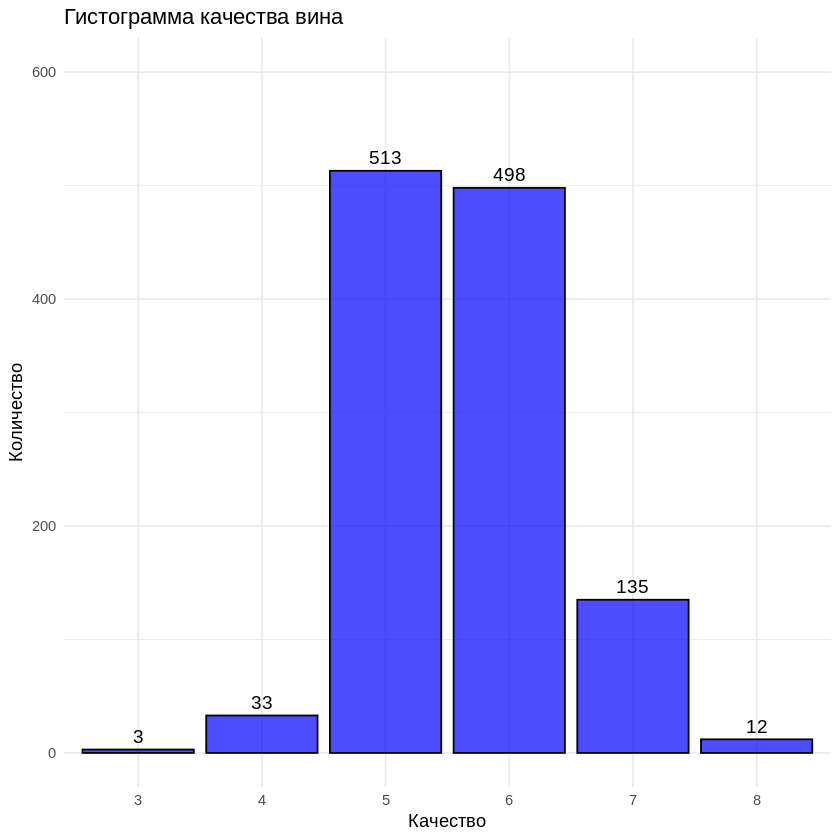

In [ ]:
library(ggplot2)


# Гистограмма
ggplot(df_no_outliers, aes(x = factor(quality))) +
  geom_bar(fill = "blue", color = "black", alpha = 0.7) +
  geom_text(stat = "count", aes(label = ..count..),
            vjust = -0.5, color = "black", size = 4) +
  scale_y_continuous(limits = c(0, 600)) +
  labs(title = "Гистограмма качества вина",
       x = "Качество",
       y = "Количество") +
  theme_minimal()

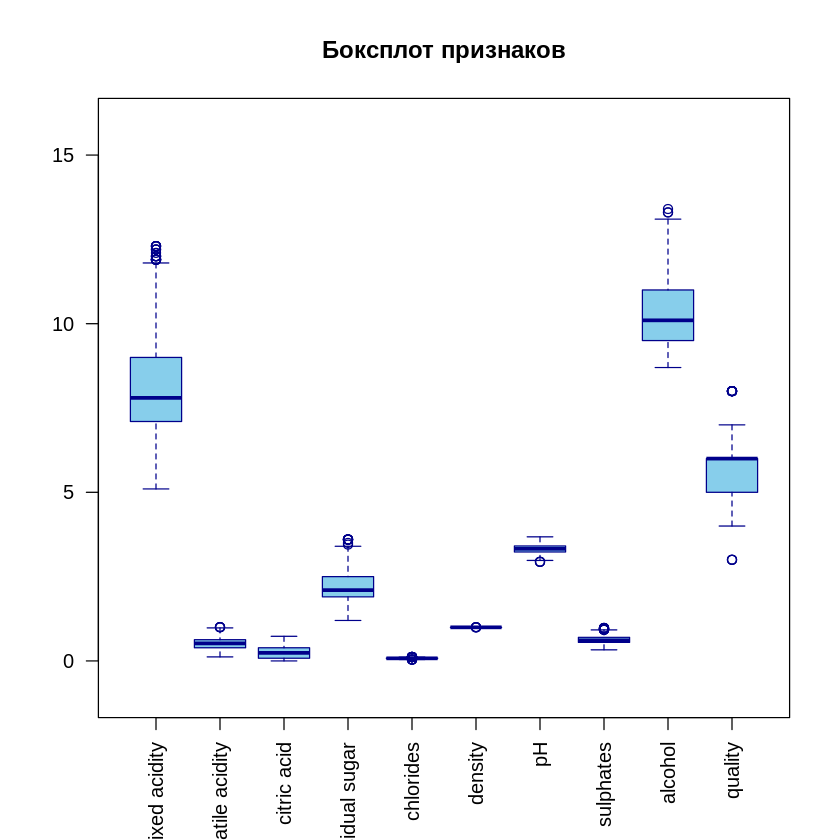

In [ ]:
# Боксплот признаков без диоксидов
df_no_outliers_subset <- subset(df_no_outliers, select = -c(`free sulfur dioxide`, `total sulfur dioxide`))

boxplot(df_no_outliers_subset,
        main = "Боксплот признаков",
        las = 2,
        col = "skyblue",
        border = "darkblue",
        ylim = c(-1, 16)
        )

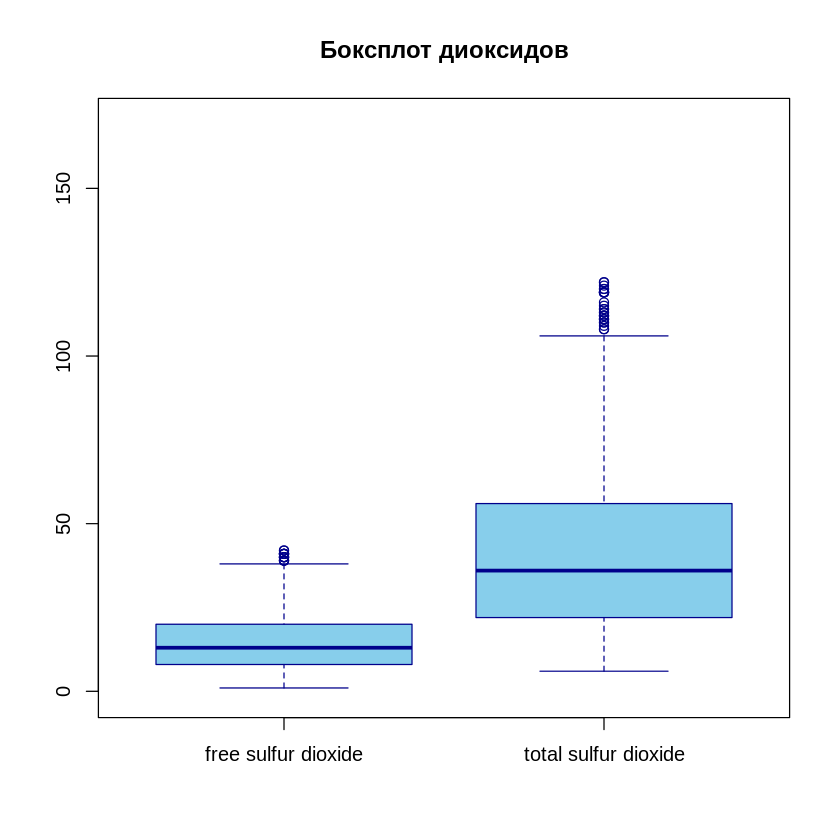

In [ ]:
# Боксплот диоксидов
df_no_outliers_dioxide <- subset(df_no_outliers, select = c(`free sulfur dioxide`, `total sulfur dioxide`))
boxplot(df_no_outliers_dioxide,
        main = "Боксплот диоксидов",
        col = "skyblue",
        border = "darkblue",
        ylim = c(-1, 170)
        )

# **Описательная статистика после обработки**

In [ ]:
colSums(is.na(df_no_outliers))

fixed acidity     volatile acidity          citric acid 
                   0                    0                    0 
      residual sugar            chlorides  free sulfur dioxide 
                   0                    0                    0 
total sulfur dioxide              density                   pH 
                   0                    0                    0 
           sulphates              alcohol              quality 
                   0                    0                    0

In [ ]:
# информация о датасете после обработки
summary(df_no_outliers)

 fixed acidity    volatile acidity  citric acid     residual sugar 
 Min.   : 5.100   Min.   :0.1200   Min.   :0.0000   Min.   :1.200  
 1st Qu.: 7.100   1st Qu.:0.3900   1st Qu.:0.0800   1st Qu.:1.900  
 Median : 7.800   Median :0.5200   Median :0.2400   Median :2.100  
 Mean   : 8.167   Mean   :0.5227   Mean   :0.2481   Mean   :2.186  
 3rd Qu.: 9.000   3rd Qu.:0.6300   3rd Qu.:0.3900   3rd Qu.:2.500  
 Max.   :12.300   Max.   :1.0050   Max.   :0.7300   Max.   :3.600  
   chlorides       free sulfur dioxide total sulfur dioxide    density      
 Min.   :0.04100   Min.   : 1.00       Min.   :  6.00       Min.   :0.9923  
 1st Qu.:0.06900   1st Qu.: 8.00       1st Qu.: 22.00       1st Qu.:0.9955  
 Median :0.07800   Median :13.00       Median : 36.00       Median :0.9966  
 Mean   :0.07848   Mean   :15.01       Mean   : 42.15       Mean   :0.9966  
 3rd Qu.:0.08700   3rd Qu.:20.00       3rd Qu.: 55.75       3rd Qu.:0.9976  
 Max.   :0.11900   Max.   :42.00       Max.   :122.00       Ma

In [ ]:
# расчет Мода Дисперсия Стандарт_откл после обработки
get_mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}


result <- data.frame(
  Мода = sapply(df_no_outliers, get_mode),
  Дисперсия = sapply(df_no_outliers, var, na.rm = TRUE),
  Стандарт_откл = sapply(df_no_outliers, sd, na.rm = TRUE)
)

print(result)

                        Мода    Дисперсия Стандарт_откл
fixed acidity         7.2000 2.134918e+00   1.461135712
volatile acidity      0.6000 2.718520e-02   0.164879358
citric acid           0.0000 3.247494e-02   0.180208033
residual sugar        2.0000 1.955054e-01   0.442159939
chlorides             0.0800 2.045028e-04   0.014300449
free sulfur dioxide   6.0000 7.777616e+01   8.819079321
total sulfur dioxide 28.0000 6.804160e+02  26.084785606
density               0.9972 2.574086e-06   0.001604396
pH                    3.3600 1.745858e-02   0.132130913
sulphates             0.5800 1.350147e-02   0.116195816
alcohol               9.5000 9.518384e-01   0.975622066
quality               5.0000 5.874785e-01   0.766471438


# **Кластеризация методом k-means**

## Определение оптимального k - силуэтный метод и метод локтя

In [ ]:
# убираем столбец quality и проводим стандартизацию
# Алгоритм k-средних (k-means) не использует целевые метки (вроде quality) при обучении
# Если не убрать целевую переменную quality кластеры могут исказиться

library(ggplot2)
df_no_outliers_1 <- subset(df_no_outliers, select = -c(`quality`))
df_scaled <- scale(df_no_outliers_1)

In [ ]:
# библиотеки
install.packages("factoextra")
install.packages("cluster")
library(cluster)
library(factoextra)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘Deriv’, ‘microbenchmark’, ‘Rdpack’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘RcppEigen’, ‘lazyeval’, ‘carData’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘crosstalk’, ‘estimability’, ‘mvtnorm’, ‘numDeriv’, ‘corrplot’, ‘viridis’, ‘car’, ‘DT’, ‘ellipse’, ‘emmeans’, ‘flashClust’, ‘leaps’, ‘multcompView’, ‘scatterplot3d’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’, ‘plyr’, ‘abind’, ‘dendextend’, ‘FactoMineR’, ‘ggpubr’, ‘reshape2’, ‘ggrepel’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



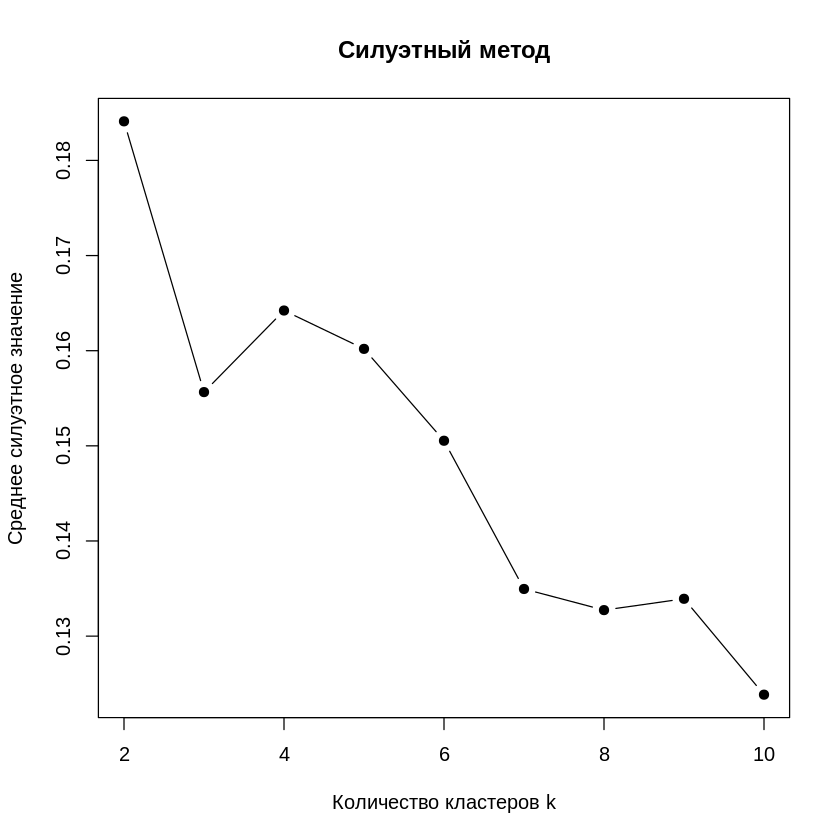

In [ ]:
# Силуэтный метод
avg_sil <- numeric(9)
for (k in 2:10) {
  km.res <- kmeans(df_scaled, centers = k, nstart = 10)
  ss <- silhouette(km.res$cluster, dist(df_scaled))
  avg_sil[k - 1] <- mean(ss[, 3])
}

plot(2:10, avg_sil, type = "b", pch = 19,
     xlab = "Количество кластеров k",
     ylab = "Среднее силуэтное значение",
     main = "Силуэтный метод")

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



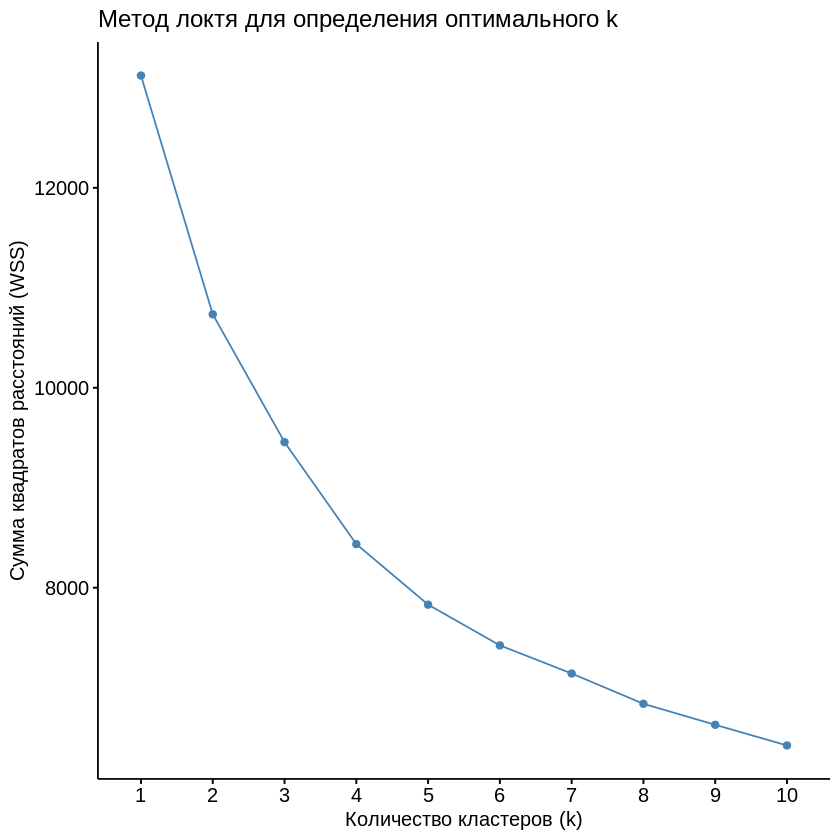

In [ ]:
# Метод локтя для определения оптимального k
fviz_nbclust(df_scaled, kmeans, method = "wss") +
  labs(title = "Метод локтя для определения оптимального k",
       x = "Количество кластеров (k)",
       y = "Сумма квадратов расстояний (WSS)")

## Запуск K-means и анализ результатов

In [ ]:
# запуск K-means
set.seed(42) # для воспроизводимости
k <- 4 # количество кластеров
kmeans_result <- kmeans(df_scaled, centers = k, nstart = 10) # nstart - количество случайных инициализаций

In [ ]:
#Анализ результатов
kmeans_result$cluster # вектор принадлежности кластеру
kmeans_result$centers # координаты центроидов
kmeans_result$tot.withinss # суммарная внутрикластерная сумма квадратов

[1] 3 1 3 2 3 3 3 3 3 3 3 1 1 1 2 1 3 3 3 2 3 3 1 3 1 3 3 2 1 3 1 2 3 1 3 3 3
  [38] 1 1 2 3 3 1 1 3 3 3 3 2 3 3 1 1 3 1 2 2 3 3 3 1 4 3 3 3 3 3 3 3 3 3 3 3 3
  [75] 3 3 3 1 3 1 1 2 3 2 3 3 1 1 1 3 3 1 4 3 4 4 3 1 3 3 1 1 1 3 3 3 3 1 3 1 1
 [112] 3 1 3 3 1 1 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 1 1 3 3 3 3 1 3 2 4 2 3 3 3 1
 [149] 1 2 1 2 1 3 3 3 3 1 1 3 3 1 1 3 1 3 4 3 1 3 3 3 3 3 3 3 2 1 3 3 1 3 3 2 3
 [186] 2 1 3 1 2 3 2 3 3 3 1 2 1 4 3 2 3 1 1 2 1 1 1 1 2 3 2 1 3 3 3 3 2 3 1 2 3
 [223] 3 2 1 1 1 1 1 1 1 1 1 1 3 1 2 1 3 4 4 1 2 2 2 2 1 4 2 3 2 3 3 4 2 2 2 1 1
 [260] 2 2 2 1 2 1 1 2 2 2 1 3 1 3 1 2 4 2 1 2 2 3 4 2 2 3 2 2 2 1 1 1 1 2 3 1 4
 [297] 3 2 3 4 4 3 3 2 1 2 2 2 2 1 2 2 3 2 2 4 3 3 2 2 3 2 4 2 1 2 2 2 3 2 2 2 2
 [334] 2 3 2 2 2 2 2 2 3 2 2 2 2 2 2 1 4 4 1 2 3 2 1 3 2 2 1 1 2 2 2 1 2 1 1 1 1
 [371] 1 1 2 2 2 2 4 2 2 2 3 1 3 2 1 3 2 3 2 2 1 1 1 4 2 4 2 2 2 2 2 1 1 2 2 2 2
 [408] 2 3 1 2 1 1 2 3 2 3 3 3 1 3 1 4 1 3 4 1 1 2 2 1 1 2 4 3 3 3 1 3 2 1 1 3 2
 [445] 1 2 1 2 3 3 4 2 2 1 3 3 3 3 2 2 1 2 2 2 1 3 3 2 2 2 3 2 3 1 3 3 3 1 1 1 3
 [482] 3 1 2 3 3 1 3 3 3 4 2 1 3 3 1 3 3 3 3 3 1 1 3 1 3 3 4 3 3 1 3 3 3 1 1 3 3
 [519] 1 1 3 1 1 3 3 1 1 1 1 3 3 3 3 1 1 3 3 3 3 1 1 1 1 3 1 3 2 1 3 1 3 1 2 2 1
 [556] 1 1 1 1 3 2 2 2 3 4 1 3 4 4 4 3 3 2 3 2 2 2 3 1 3 3 3 3 3 4 3 4 4 3 4 3 3
 [593] 2 3 2 3 1 1 2 3 3 3 3 3 2 2 1 1 4 1 4 2 4 1 3 1 1 1 4 4 4 3 4 3 1 2 2 2 3
 [630] 4 1 3 4 1 3 3 2 4 1 1 2 1 1 3 4 3 4 4 3 3 1 1 3 1 4 2 4 4 1 4 2 1 4 4 1 4
 [667] 4 3 1 3 4 4 2 4 4 4 2 2 2 4 4 4 4 4 4 4 4 2 2 2 3 4 3 3 2 4 4 2 1 4 3 2 2
 [704] 2 4 1 1 1 4 2 2 3 2 2 3 2 1 3 2 3 1 1 1 1 3 3 4 2 4 4 1 4 4 4 2 1 4 2 3 3
 [741] 2 4 3 3 2 3 3 4 4 1 3 3 3 3 3 2 4 3 1 3 3 1 4 4 3 1 2 2 1 4 4 1 1 2 2 4 2
 [778] 2 4 3 4 2 2 1 4 1 1 2 2 1 4 1 1 4 2 2 1 4 4 4 2 3 3 4 4 4 4 4 4 4 4 3 3 4
 [815] 2 3 3 3 4 4 4 4 2 3 4 4 1 1 3 4 4 2 2 1 1 1 4 4 1 1 4 2 4 4 3 2 3 4 2 2 2
 [852] 4 3 3 2 4 4 4 2 4 2 1 1 4 4 4 4 2 1 3 1 4 4 1 3 4 3 3 1 3 4 1 3 4 4 4 4 4
 [889] 4 4 3 1 3 2 2 2 1 2 4 1 2 1 2 1 4 1 2 4 3 4 3 1 1 4 1 3 3 3 4 3 3 1 3 3 4
 [926] 1 3 4 3 3 2 1 4 4 1 3 1 3 1 2 1 1 3 1 4 2 4 4 3 1 4 3 1 4 3 4 4 1 1 1 1 3
 [963] 1 4 1 1 1 2 1 1 4 4 4 4 4 4 3 1 1 3 3 4 3 3 3 3 3 3 3 3 2 3 4 3 3 3 1 4 3
[1000] 3 3 3 3 1 2 2 3 2 3 3 3 3 1 3 1 3 3 3 3 3 1 1 1 1 3 3 1 4 3 3 1 3 3 1 3 3
[1037] 4 1 4 4 4 3 4 1 2 3 2 4 3 3 1 4 2 2 4 4 3 4 4 1 4 4 3 1 4 3 4 1 3 3 1 4 4
[1074] 2 4 1 2 3 4 1 4 4 1 3 3 3 1 1 1 1 3 4 4 2 3 2 3 4 3 3 3 4 4 4 4 4 4 3 4 3
[1111] 3 4 2 3 3 2 2 4 4 3 3 4 4 4 2 3 4 3 4 1 4 3 3 4 1 1 4 3 3 1 4 3 3 4 4 1 4
[1148] 3 2 4 4 3 4 2 4 3 3 3 3 4 3 3 3 3 3 4 4 3 3 4 1 4 4 2 3 4 4 4 4 1 4 4 4 4
[1185] 4 4 3 4 3 3 4 4 3 4

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1,-0.001721345,0.08025017,0.0722974945,0.3856275,0.4326451,0.9249094,1.3007507,0.43218152,-0.05114237,-0.1822558,-0.5270456
2,1.391389524,-0.74018137,1.1918114996,0.1628211,0.2035159,-0.5574354,-0.5675309,0.74571396,-0.94102321,0.4209079,0.1132729
3,-0.481020312,0.65337337,-0.7625540032,-0.2935614,0.1083446,-0.4031873,-0.4367827,-0.03186038,0.34105342,-0.4257403,-0.4620579
4,-0.587174027,-0.45623793,0.0003626215,-0.1357924,-0.9136681,0.1211251,-0.2681428,-1.22262902,0.43401122,0.5169641,1.3071293


[1] 8436.046

In [ ]:
# доля объясненной дисперсии - это метрика, которая показывает,
# какую часть общей изменчивости (дисперсии) в данных описывает та или иная компонента
# после снижения размерности

# межгрупповая дисперсия / общая дисперсия

explained_var <- kmeans_result$betweenss / kmeans_result$totss
print(explained_var)

[1] 0.3571557


## Визуализация в пространстве PCA с границами кластеров

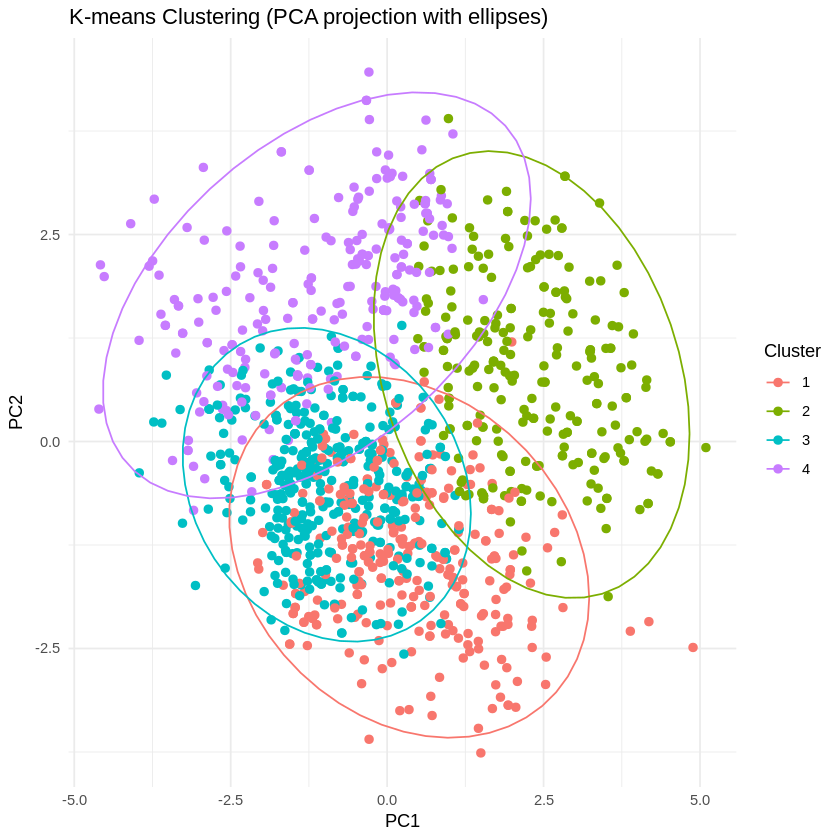

In [ ]:
#Визуализация в пространстве PCA с границами кластеров
library(ggplot2)
pca_res <- prcomp(df_scaled)
df_pca <- data.frame(pca_res$x[,1:2], Cluster = factor(kmeans_result$cluster))
ggplot(df_pca, aes(x = PC1, y = PC2, color = Cluster)) +
  geom_point(size = 2) +
  stat_ellipse(type = "norm", linetype = 1) +  # добавляет эллипсы
  ggtitle("K-means Clustering (PCA projection with ellipses)") +
  theme_minimal()

In [ ]:
# контингентная (частотная) таблица - сколько объектов с тем или иным качеством попало в каждый кластер
clusters <- kmeans_result$cluster
df_no_outliers$cluster <- as.factor(clusters)
table(df_no_outliers$cluster, df_no_outliers$quality)

   
      3   4   5   6   7   8
  1   0   7 175 104   8   1
  2   1   4  71 122  44   3
  3   2  22 229 148  10   0
  4   0   0  38 124  73   8

## Визуализация распределения качества вина по кластерам

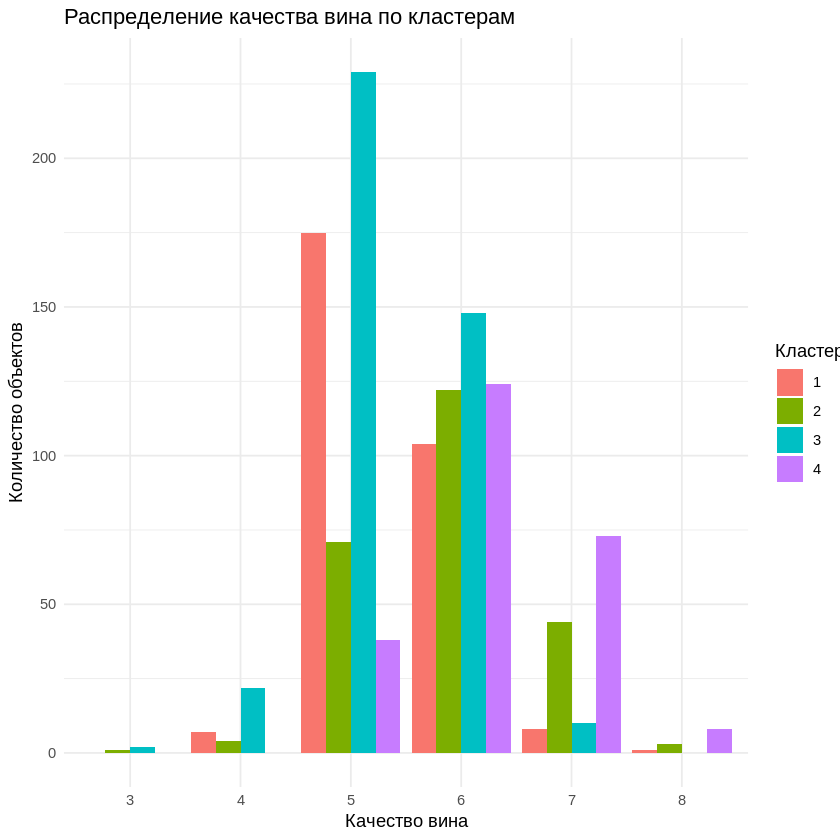

In [ ]:
# визуализация распределения качества вина по кластерам
library(ggplot2)
df_no_outliers$cluster <- as.factor(kmeans_result$cluster)

tbl <- as.data.frame(table(df_no_outliers$cluster, df_no_outliers$quality))
colnames(tbl) <- c("Cluster", "Quality", "Count")

ggplot(tbl, aes(x = Quality, y = Count, fill = Cluster)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Распределение качества вина по кластерам",
       x = "Качество вина",
       y = "Количество объектов",
       fill = "Кластер") +
  theme_minimal()

In [ ]:
# таблица по категориям
df_no_outliers$quality_group <- cut(df_no_outliers$quality,
                          breaks = c(0, 5, 7, 10),
                          labels = c("Low", "Medium", "High"))

table(df_no_outliers$cluster, df_no_outliers$quality_group)

   
    Low Medium High
  1 182    112    1
  2  76    166    3
  3 253    158    0
  4  38    197    8

In [ ]:
install.packages("mclust")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Adjusted Rand Index
library(mclust)

ari <- adjustedRandIndex(kmeans_result$cluster, df_no_outliers$quality)
print(ari)

Package 'mclust' version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



[1] 0.0653935


## Экспорт результатов

In [ ]:
head(df_no_outliers)

fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,cluster
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,3
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,1
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,3
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,2
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,3
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,3


In [ ]:
install.packages("writexl")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# экспорт файла в формате xlsx
library(writexl)
write_xlsx(df_no_outliers, path = "wine_kmeans_clusters.xlsx")

# Иерархическая кластеризация

## Построение дендрограммы

In [ ]:
# построение дерева
dist_matrix <- dist(df_scaled, method="euclidean") # матрица расстояний
hc <- hclust(dist_matrix, method="ward.D2") # ward.D2 часто используется

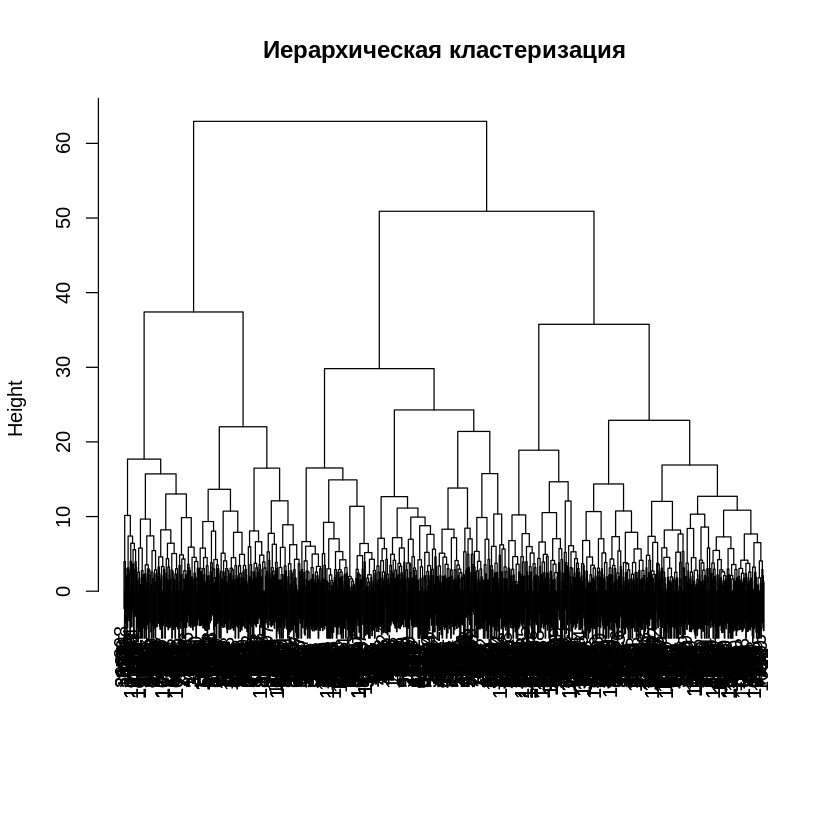

In [ ]:
# построение дендрограммы
plot(hc, main="Иерархическая кластеризация", xlab="", sub="")

## Результаты

In [ ]:
#Выделение кластеров
clusters <- cutree(hc, k=4)
table(clusters)

clusters
  1   2   3   4 
478 386 140 190 

In [ ]:
# матрица расстояний между центроидами кластеров
aggregate(df_no_outliers, by = list(cluster = clusters), FUN = mean)  # центроиды кластеров
centroids <- aggregate(df_no_outliers, by = list(cluster = clusters), FUN = mean)[, -1]
dist(centroids)  # попарные расстояния между кластерами

cluster,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7.190167,0.6158891,0.1053138,2.030335,0.07433682,13.738494,33.74895,0.9958713,3.391172,0.5997908,10.321688,5.493724
2,8.351554,0.5474093,0.2597927,2.366451,0.08739896,18.647668,62.77202,0.9974384,3.308316,0.6118135,9.874611,5.414508
3,10.518571,0.3715714,0.5016429,2.316429,0.07857857,9.164286,25.65000,0.9982223,3.189000,0.7018571,10.281190,5.878571
4,8.514211,0.3496316,0.3968947,2.113421,0.07069474,15.100000,33.57895,0.9953552,3.286421,0.7037895,11.533684,6.294737


          1         2         3
2 29.464251                    
3  9.904261 38.381896          
4  2.435337 29.470433 10.194240

In [ ]:
# Adjusted Rand Index
library(mclust)

adjustedRandIndex(clusters, df_no_outliers$quality)

[1] 0.06289062

## Визуализация кластеризации

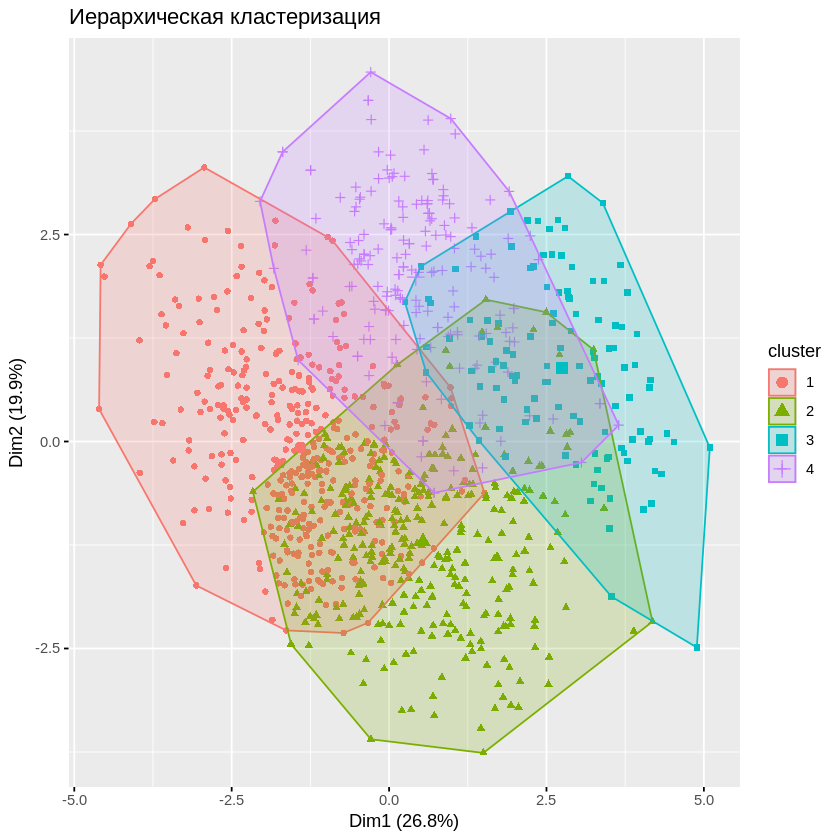

In [ ]:
#визуализация кластеризации
library(factoextra)

fviz_cluster(list(data = df_scaled, cluster = clusters),
             geom = "point", main = "Иерархическая кластеризация")